# Custom eReefs Data Access using Pydap

This will be a lesson around the use of pydap to extract a map of chlorophyll maximum values from the eReefs thredds/opendap system.

---
#### Plotting Notes
In order to plot nice coastlines etc we also need to install some extra things into our python environment. You are unlikely to have these pre-installed so if you wish to do the plotting as shown in this notebook please open another terminal window and run:
```bash
pip install cartopy # or something like this...
```

In [1]:
# importing pydap so that we can connect to the ereefs opendap/thredds system
from pydap.client import open_url
# importing pandas so that we can use the pandas data frames to store the data in a nice way.
import pandas as pd
# importing numpy so that we can use it's math functions.
import numpy as np
# import some cartopy stuff for plotting.
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs

In [2]:
# command allows our plots to show up inside this ipython notebook -
#    it is not needed of you're running code outside of an ipython notebook
%matplotlib inline

## Find a file URL

Browse the THREDDS catalog [http://ereeftds.bom.gov.au/ereefs/tds/catalog.html](http://ereeftds.bom.gov.au/ereefs/tds/catalog.html) to find the opendap url's for the files you're interested in retrieving.

e.g:
```bash
http://ereeftds.bom.gov.au/ereefs/tds/dodsC/ereef/mwq/P1A/A20140101.316.P1A.ANN_MIM_RMP.nc
```

The pydap package can retreive the entire catalog in xml (or similar) and you can write code to find the data you're interested in and automatically retrieve the relevent data URL's. We will not teach this here and will focus on the retreivel of single data files. if you wish to know more about what pydap can do please see: [http://www.pydap.org/](http://www.pydap.org/)


In [3]:
# Use pydap to connect to the file through opendap.
file_object = open_url("http://ereeftds.bom.gov.au/ereefs/tds/dodsC/ereef/mwq/P1A/A20140101.316.P1A.ANN_MIM_RMP.nc")

## Get some meta-data

In [4]:
# Ask OpenDAP to get all the dataset keys to access the variables in this file.
file_keys = file_object.keys()

# just print the top 10 so that we can see it worked.
print file_keys[1:10]

['lat', 'lon', 'Chl_MIM_n_obs', 'Chl_MIM_n_cloud', 'Chl_MIM_n_valid_obs', 'Chl_MIM_pc_cloud', 'Chl_MIM_pc_valid_obs', 'Chl_MIM_minimum', 'Chl_MIM_maximum']


## Get the information about the Chlorophyll maximum and the lat and lon data.

In [5]:
chl_max_object = file_object['Chl_MIM_maximum']
lon_object = file_object['lon']
lat_object = file_object['lat']

In [6]:
# ask the chlorophyll max object what it's dimensions are and what the fill or missing data value is:
print chl_max_object.dimensions
print 'Chl fill value is:', chl_max_object.attributes['_FillValue']
# just save this fill value for later use:
chl_fill_value = chl_max_object.attributes['_FillValue']

('time', 'lat', 'lon')
Chl fill value is: 1.00000002004e+20


## Actually download the data we've been looking at.

In [7]:
# actually downloads the data here. Up until now we've just been talking over the network and playing with the thredds data catalog
chl_max_data = np.array(chl_max_object[:])
lon_data = np.array(lon_object[:])
lat_data = np.array(lat_object[:])

In [8]:
# Now that we've got the data just check that it's sensible by looking at it's dimensions again:
chl_max_data.shape

(1, 1600, 1400)

In [9]:
# We don't need the time dimension being 1 and so we can remove it using numpy's squeeze function.
chl_max_data = np.squeeze(chl_max_data, axis=(0,))
print chl_max_data.shape

(1600, 1400)


## Now you've got data from the original netcdf files you can do lots of cool stuff

In [10]:
# we can look at it
print chl_max_data

[[  1.13183594e+00   1.24707031e+00   1.22070312e+00 ...,   2.71484375e-01
    2.72460938e-01   2.70507812e-01]
 [  1.13183594e+00   1.13183594e+00   1.24707031e+00 ...,   2.68554688e-01
    2.56835938e-01   2.56835938e-01]
 [  8.96484375e-01   1.57421875e+00   1.57421875e+00 ...,   2.16796875e-01
    2.71484375e-01   2.71484375e-01]
 ..., 
 [  1.00000002e+20   1.00000002e+20   1.00000002e+20 ...,   4.37500000e-01
    2.94921875e-01   3.54492188e-01]
 [  1.00000002e+20   1.00000002e+20   1.00000002e+20 ...,   3.63281250e-01
    2.67578125e-01   3.54492188e-01]
 [  1.00000002e+20   1.00000002e+20   1.00000002e+20 ...,   2.76367188e-01
    2.76367188e-01   2.76367188e-01]]


In [11]:
# We can mask the missing data:
masked_chl_max_data = np.ma.masked_equal(chl_max_data, chl_fill_value)
print masked_chl_max_data

[[1.1318359375 1.2470703125 1.220703125 ..., 0.271484375 0.2724609375
  0.2705078125]
 [1.1318359375 1.1318359375 1.2470703125 ..., 0.2685546875 0.2568359375
  0.2568359375]
 [0.896484375 1.57421875 1.57421875 ..., 0.216796875 0.271484375
  0.271484375]
 ..., 
 [-- -- -- ..., 0.4375 0.294921875 0.3544921875]
 [-- -- -- ..., 0.36328125 0.267578125 0.3544921875]
 [-- -- -- ..., 0.2763671875 0.2763671875 0.2763671875]]


### We can plot it

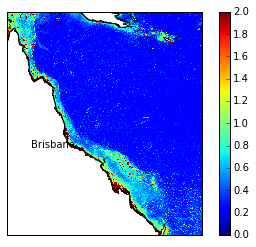

In [12]:
# Define a Cartopy 'ordinary' lat-lon coordinate reference system.
crs_latlon = ccrs.PlateCarree()
ax = plt.axes(projection=crs_latlon)
# Set display limits to include a set region of latitude * longitude.
# (Note: Cartopy-specific).
ax.set_extent((np.min(lon_data), np.max(lon_data), np.max(lat_data), np.min(lat_data)), crs=crs_latlon)
# Add coastlines and meridians/parallels (Cartopy-specific).
ax.coastlines(resolution='50m', color='black', linewidth=0.75)
#ax.gridlines(crs=crs_latlon, color='grey',linestyle='-')

plt.pcolormesh(lon_data, lat_data, masked_chl_max_data,vmin=0,vmax=2, transform=crs_latlon)
ax.text(146.8183, -19.2564, 'Brisbane' , color='Black', ha='right', transform=crs_latlon)
plt.colorbar()
#ax.stock_img()
ax.coastlines()
# save the figure:
plt.savefig('foo.png', bbox_inches='tight', format='png', dpi=200)

plt.show()